# Introduction: XRD timescan with electrochemistry

This demonstration will show how to use the <b>EC_Xray</b> python package to synchronize XRD and electrochemistry data and display the combined dataset. The <b>EC_Xray</b> package is developed and maintained by Soren Scott, and is available at https://github.com/ScottSoren/. 

For a more basic introduction to the <b>EC_Xray</b> package's treatment of XRD data, and for calculation of a full XRD spectrum, see the other jupyter notebook.

The data used in this demonstration is from SSRL Beamline 2.1

The sample is a metallic thin film, with a metallic XRD peak at tth=20. It has grown a native oxide with a peak at tth=17. The 2-D X-ray detector is set to tth=18.8, where it catches both the metallic and the oxide peak. The pilatus detector is set to record an image every few seconds while the sample is reduced electrochemically.

# Setting up

EC_Xray should be added to your python path to import these classes and functions.

(The first three lines are just to format jupyter notebook to print figures well to pdf)

In [1]:
%matplotlib inline                 
import matplotlib as mpl 
mpl.rcParams['figure.dpi']= 200 

import numpy as np
import matplotlib.pyplot as plt

from EC_Xray import ScanImages      # class for scans of pilatus images
from EC_Xray import load_EC_set     # function loading EC data
from EC_Xray import sync_metadata   # function calibrating EC data
from EC_Xray import time_cal        # function calibrating time axes
from EC_Xray import synchronize     # function combining datasets
from EC_Xray import plot_experiment # function plotting combined data

EC_Xray will soon have a function for getting calibration information from a calibration scan, but for now we use the information calculated from an older script. The calibration is stored as a dictionary in the cell below

In [2]:
calibration = {'direct_beam_x': 277,
               'direct_beam_y': 91,
               'Sample_Detector_distance_pixels': 4085.27,
               'Sample_Detector_distance_mm': 702.666}

# The X-ray diffraction data

## Importing the timescan

The next cell imports the scan, combining data from the .csv file and Pilatus images, both as output by SPEC on beamline 2.1 and 11.2, into a <b>ScanImages</b> object. This object is the center of the action in <b>EC_Xray</b>. 

The initiation is the same here, for a timescan, as in the other jupyter notebook, for a tth scan. The only additional inputs are:

* The <b>tth</b> value. This is needed because SPEC does not save the TwoTheta value in the .csv for a timescan 
* The timezone, <b>tz</b>. This enables the program to calculate a correct absolute (epoch) time for the scan start, helping with synchronization of the x-ray and electrochemistry datasets. If you happen to be at the synchrotron at the middle of the night while the local clock jumps an hour due to daylight savings time, like we were, no worries, the timezone information enables python to get the correct absolute time for all the datasets.

In [3]:
scan = ScanImages(csvfile = './data/time_scan.csv',  
                  pilatusfilebase = './data/Pilatus/time_scan', 
                  calibration = calibration,  
                  yslits=[60, 430],   
                  scan_type = 'time', 
                  tth = 18.8,         
                  tz = 'US/Pacific',  
                  verbose=True,       
                  )

Loading Scan: directory = ./data,
	name = time_scan


function 'load_from_file' at your service!



function 'import_text' at your service!

directory: ./data
importing data from time_scan.csv
Was able to readlines() with encoding utf8

function 'import_text' finished!




function 'text_to_data' at your service!

Data starting on line 1

getting epoch time given a timestamp local to US/Pacific
timestamp_to_unix_time' didn't receive a string. Returning the argument.

function 'text_to_data' finished!


Couldn't get creation time! Returing modified time.
In linux. Using os.stat('./data/time_scan.csv').st_mtime as tstamp.

function 'load_from_file' finished!




function 'get_images' at your service!

982 items in ./data/Pilatus
 of which 240 are image files including 'time_scan'

function 'get_images' finished!


This is a timescan but there's no time variable specified. 
Consider using EC_Xray.time_cal() to calibrate and specify one.
ScanImages object with name time_scan imported!




## Plotting images from the timescan

As before, the scan can be indexed to return an individual pilatus image. To illustrate this, the first pilatus image and corresponding tth spectrum are plotted by the code here.

calculating spectrum for time_scan_0000.raw
calculating spectrum for time_scan_0239.raw


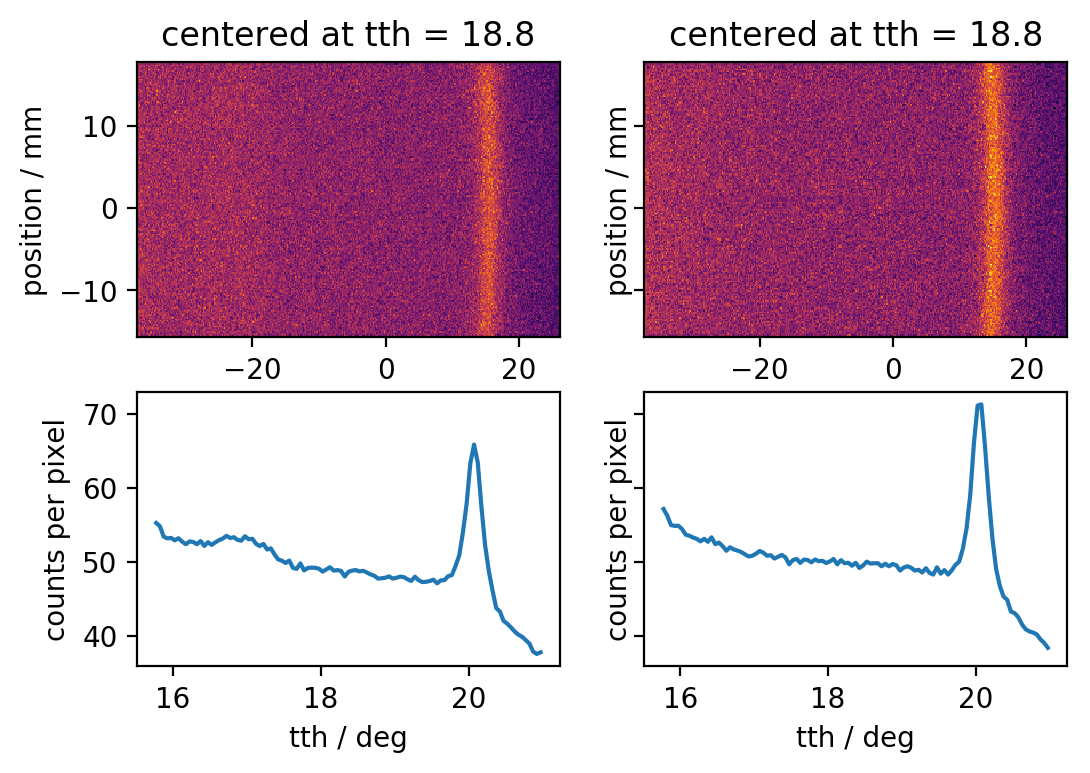

In [4]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(ncols=2, nrows=2, sharey='row')
scan[0].show_image(ax=ax1)
scan[-1].show_image(ax=ax2)
scan[0].plot_spectrum(ax=ax3)
scan[-1].plot_spectrum(ax=ax4)

## Calculating all image spectra

The spectrum changes between the first and final image. The diffuse peak at tth~=17 disappears. But when and how fast, at what electrochemical potential, and does anything else happen in between? To answer these, we need to calculate all of the image spectra, plot them in a graspable way, and to combine the dataset with the electrochemistry data.

The first is accomplished in one line with <b>EC_Xray.ScanImages.get_stacked_spectra()</b>. This function calculates the local (one spectrum for each image) and global (all images added) XRD spectra, saving the former in a (N images)x(N tth intervals) numpy array called <b>scan.spectra</b> and the latter in a 2x(N tth intervals) numpy array called <b>scan.spectrum</b> where the first is tth and the second is (averaged?) counts.

<b>EC_Xray.ScanImages.get_stacked_spectra()</b> can take the same arguments as <b>EC_Xray.ScanImages.get_combined_spectra()</b> in the other notebook. By default, <b>stepsize = 0.5 </b>, <b>method = 'sum'</b>, and <b>scan_method = 'sum'</b>.

In [5]:
scan.get_stacked_spectra(); # tth spectra calculation!



function 'get_stacked_spectra' at your service!



function 'get_combined_spectrum' at your service!

t = 0
calculating tth spectrum for each of 240 images, storing in Pilatus objects, and adding them all up.
Counts per tth interval calculated locally and globally. 
Converted to global tth spectrum and stored in ScanImages oject.
t = 4.6571736335754395 seconds.

function 'get_combined_spectrum' finished!


self.spectra.shape = (240, 105)

function 'get_stacked_spectra' finished!




## Calibrating the time variable
It turns out that SPEC saved the time relative to some arbitrarily defined start of the timescan in the TwoTheta column of the .csv data. So, specifying a time variable could be done easily by just setting <b>scan.timecol = 'TwoTheta'</b>. However, we may as well do it in an absolutely useful way, since this will help to synchronize with electrochemistry data later.

This is done best with the <b>EC_Xray.time_cal()</b> function. This function is a very versatile way to get the time of a dataset right. It takes a column in the dataset that varies linearly with time, transforms it into the true time based on the synchronization points given (or just shifts it if only one synchronization point is given), and stores it. It takes the following arguments:

* <b>data</b> is the dataset to calibrate. The dataset should be a dictionary containing columnheaders as keys and data as values. The <b>EC_Xray.ScanImages</b> object maintains such a dataset, here called <b>scan.data</b>.
* <b>ref_data</b> is the dataset against which to calibrate. It can be easiest to do an absolute time calibration instead, i.e., to seconds since midnight Jan 1 1970 UTC. In this case just set this argument to <b>'epoch'</b>.
* <b>points</b> is a list of pairs of simultaneous datapoints or times between the two datasets.
* <b>point_type</b> tells how to interpret the above points. Options are <b>time</b>, <b>'timestamp'</b>' (like <b>'16:20:00'</b>), or <b>'index'</b>.
* <b>timecol</b> is the key to associate with the calibrated time variable in the dataset. i.e., <b>scan.data['t']</b> will contain the calibrated time data after running the function call here.
* <b>reftimecol</b> is the key pointing to the reference time data in the <b>ref_data</b>. This is not needed when calibrating to epoch time.
* <b>pseutodimecol</b> is the key pointing to the uncalibrated time data in <b>data</b>.

For an accurate absolute time, I used the last-modified time (in epoch time) of the first image metadata file, (time_scan_0000.raw.pdi), on the SSRL account. It's important to ssh to the original place the file was saved, because the last-modified time apparently isn't preserved when copying using sftp (thus the huge offsets in the output below). This method, I think, is accurate to the time between images, approx +/-3 s here. <i>SPEC will store absolute time in a more convenient way in the future!</i>

The code below sets the time of the 0'th datapoint to 1509855857 s since epoch, and uses the <b>TwoTheta</b> column (where SPEC stored the relative time during this timescan) from there, saving the corrected time with respect to <b>scan.data['tstamp']</b>, as <b>scan.data['t']</b>.


In [6]:
time_cal(scan.data,
         ref_data = 'epoch',
         points = [0, 1509855857],
         point_type = ['index', 'time'],
         timecol = 't',
         pseudotimecol = 'TwoTheta'
         );



function 'time_cal' at your service!

time calbration referenced to absolute time! point_type[1] must be 'time'.
tstamp offset = -1518469932.7944186
Got 1 out of 1 points!
offset with respect to ref tstamp = 1509855856.99
total offset = -8614075.80902

function 'time_cal' finished!




## Plotting all spectra simultaneously

Now that there is time data in the default location, <b>scan.data['t']</b>, we can plot the entire timescan using the <b>EC_Xray.ScanImages.heat_plot()</b> function. The time variable is relative to the dataset's timestamp (<b>scan.data['tstamp']</b>) which, unfortunately, is when I copied it using sftp some weeks after the experiment. The important thing is that the time variable together with the dataset's timestamp together give an accurate absolute time.

Notice that the oxide peak dissapears rather suddenly and that the metal peak becomes more intense at the same time.


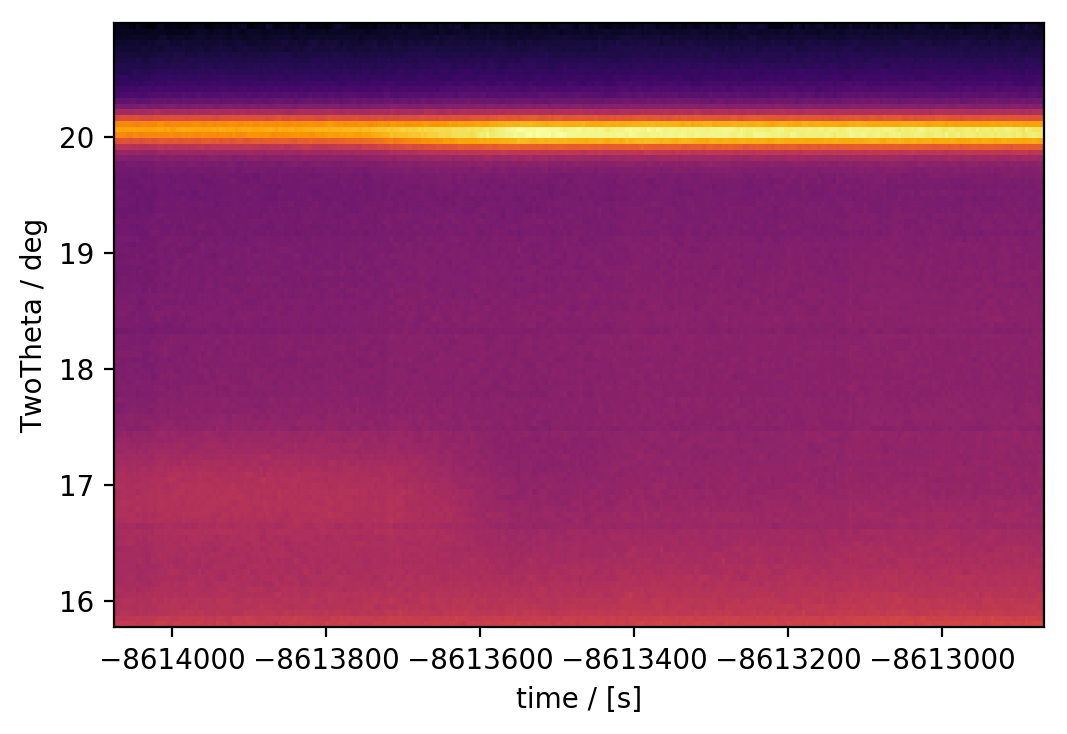

In [7]:
scan.heat_plot()

# The electrochemistry data

## Importing a set of EC-Lab text files

<b>EC_Xray</b> so far only supports electrochemistry data in the text format output by Biologic's EC-Lab. It is, however, quite versitile and powerful in its ability to import and analyze this data. 

EC-Lab saves one file for each technique used as a program. These files can be imported as individual datasets using <b>EC_Xray.load_from_file()</b>, or imported and combined all at once (via <b>EC_Xray.synchronize()</b>) using <b>EC_Xray.load_EC_set()</b>. Either way, the EC data is stored, like the scan .csv data, as a python dictionary with column headers as keys. 

One nice thing about the EC-Lab files is that they store the time of acquisition start in the file header, which <b>EC_Xray</b> reads and stores as an epoch time in <b>EC_data['tstamp']</b>, as shown here. This means that the time variable of the electrochemistry data, <b>EC_data['time/s']</b> together with the timestamp gives absolute time to about +/- 1 s. One must use triggers if a better time synchronization is needed than this.

In [8]:
EC_data = load_EC_set('./data/EC',      # location of data
                      tag = '01',       # start of filenames
                      tz = 'US/Pacific',# for correct epoch time
                      verbose=False)    # talks quite a lot otherwise
print(EC_data['tstamp'])

1509852624.0


## Calibrating and plotting the EC data

Reference electrode calibration and normalization of current to electrode area are done with <b>EC_Xray.sync_metadata()</b>. This function does something simple in a very robust and versitile way. Both <b>RE_vs_RHE</b> (the reference electrode potential on the RHE scale in volts) and <b>A_el</b> (the electrode area in cm^2) are optional, and <b>EC_data</b> stores metadata on which of its variables have been calibrated and what they're called, so that plotting functions (like <b>EC_Xray.plot_experiment()</b>, below) can by diffault plot calibrated data if available.

<b>EC_Xray.sync_metadata()</b> outputs the names of the calibrated potential and current. This makes it easy to plot them, like is done here.

You can see that the three files that have been combined: open-circuit data (J = 0) up to about 3300s (relative to the dataset's timestamp, which is the start of the EC-Lab acquisition), a linear sweep voltammagram up to about 3900 s, and a chronoamperometric aka constant-potential step after that at 0 V vs RHE. You can also see that the electrochemistry data is very noisy, as we hadn't optimized the EC-Lab settings for this beamtime


syncing metadata for (01_OCV.mpt) as 0, (01_LSV.mpt) as 1, and (01_CA.mpt) as 2

added U vs RHE / [V] to data_cols
added J / [mA/cm^2] to data_cols


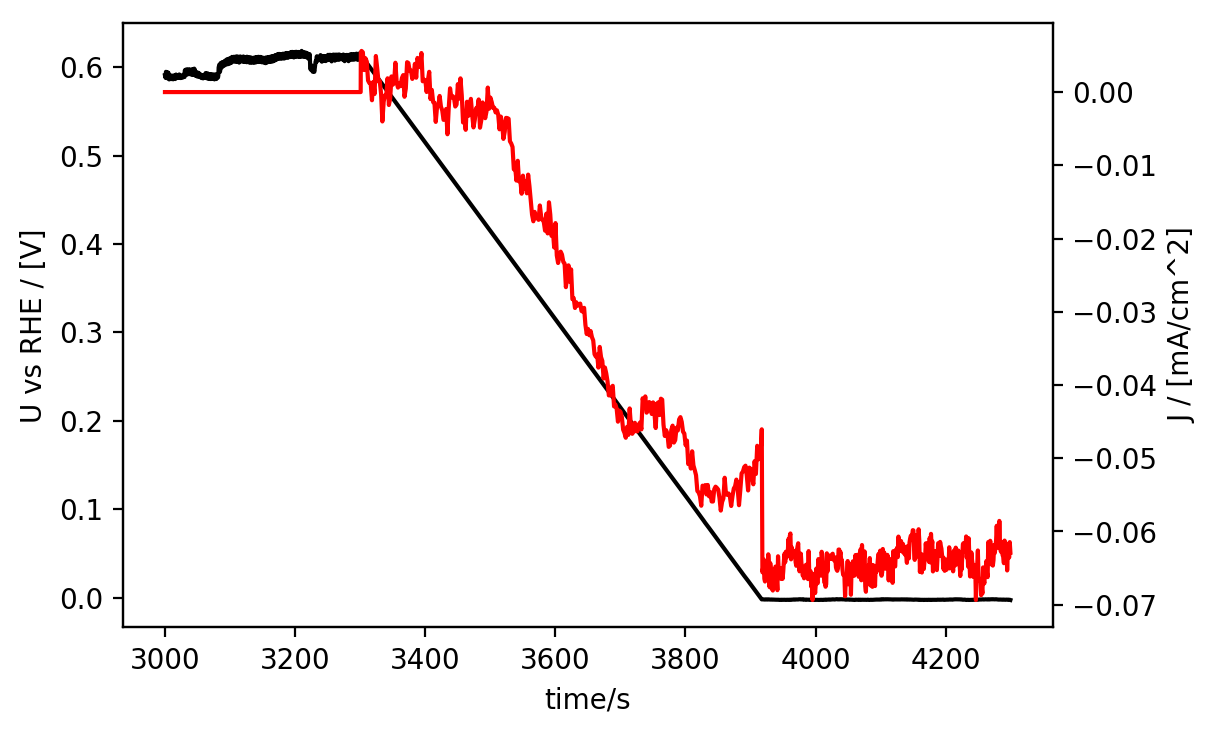

In [9]:
V_str, J_str = sync_metadata(EC_data,
                             RE_vs_RHE = 0.918,
                             A_el = 0.30, 
                             ) 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(EC_data['time/s'], EC_data[V_str], 'k')
ax2.plot(EC_data['time/s'], EC_data[J_str], 'r')
ax1.set_xlabel('time/s')
ax1.set_ylabel(V_str)
ax2.set_ylabel(J_str)

# The combined dataset

## Data synchronization

As both the XRD timescan and electrochemistry datasets are absolutely calibrated in time, combining them is straightforward! It is accomplished with the badass <b>EC_Xray.synchronize()</b> function.

This function returns the combined dataset, but also updates <b>scan.data</b> to include the electrochemsitry data. The dataset stores metadata includingan updated timestamp corresponding by default to the start of the overlap of the datasets (<b>scan.data['tstamp']</b>), and the timespan of the overlap(<b>scan.data['tspan']</b>, printed below). Both the EC and XRD time variables are now relative to <b>scan.data['tstamp']</b>.

In [10]:
synchronize([scan, EC_data],
            verbose = False, # also a noisy function
            );  
print(scan.data['tspan'])

[0.0, 1066.3768939971924]


## Plotting everything

Now we have the synchronized and combined dataset, with everything calibrated and spectra calculated. We're ready to plot this. If you thought this would be tough, think again! EC_Xray.plot_experiment() does it all, returning axes handles that you can modify.

In this plot, we have the native oxide at OCV, which dissapears as the potential is scanned cathodic at about 475 s, as the potential crosses about 0.25 V vs RHE. The metallic peak gets more intense at the same time. This corresponds to the dip in current.




function 'plot_experiment' at your service!


syncing metadata for (time_scan.csv) as 0, and ((01_OCV.mpt) as 0, (01_LSV.mpt) as 1, and (01_CA.mpt) as 2) as 1

... already sync'd! 


function 'plot_experiment' finished!




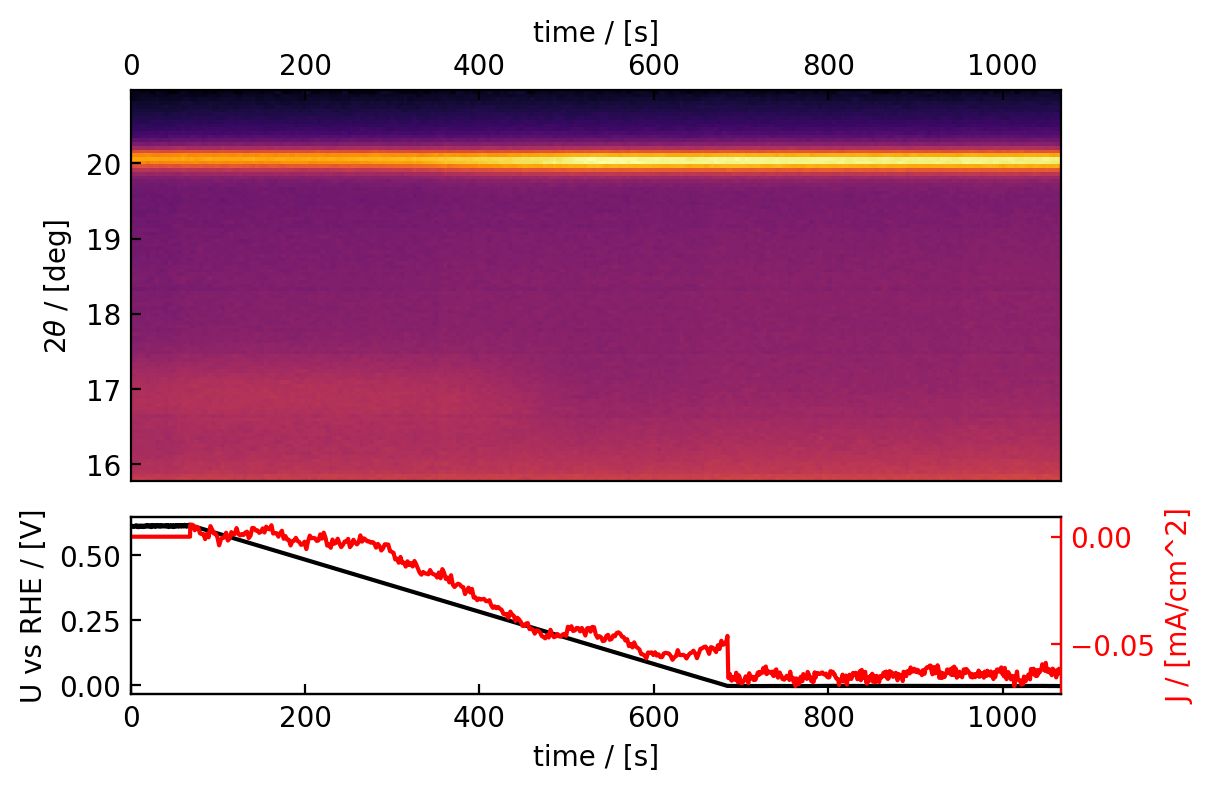

In [11]:
ax = plot_experiment(scan, plot_type='heat')
ax[0].set_ylabel(r'2$\theta$ / [deg]')

## Peak integration

In case the beautiful heat plots are not convincing enough, you can integrate peaks and plot the integrals. Integrals can be calculated using the <b>EC_Xray.ScanImages.integrate_peaks()</b> function. It takes an argument <b>peaks</b> which is a dictionary with peak names as keys and a tuple consisting of the peak's tth interval followed by the color you want it to be plotted with. There are a number of other parameters including <b>background</b>, i.e., whether to subtract a local background when integrating the peaks. By default the background is a line connecting the endpoints.

Once calculated, the peaks are in <b>scan.data</b>. They can then be plotted using <b>EC_Xray.plot_experiment()</b> with the argument <b>plot_type='peaks'</b> as shown here.



function 'integrate_peaks' at your service!


function 'integrate_peaks' finished!




function 'plot_experiment' at your service!


syncing metadata for (time_scan.csv) as 0, and ((01_OCV.mpt) as 0, (01_LSV.mpt) as 1, and (01_CA.mpt) as 2) as 1

... already sync'd! 




function 'plot_simple' at your service! 
 Plotting from: (time_scan.csv) as 0, and ((01_OCV.mpt) as 0, (01_LSV.mpt) as 1, and (01_CA.mpt) as 2) as 1
plotting: metal
plotting: oxide
function 'plot_simple' finsihed! 


function 'plot_experiment' finished!




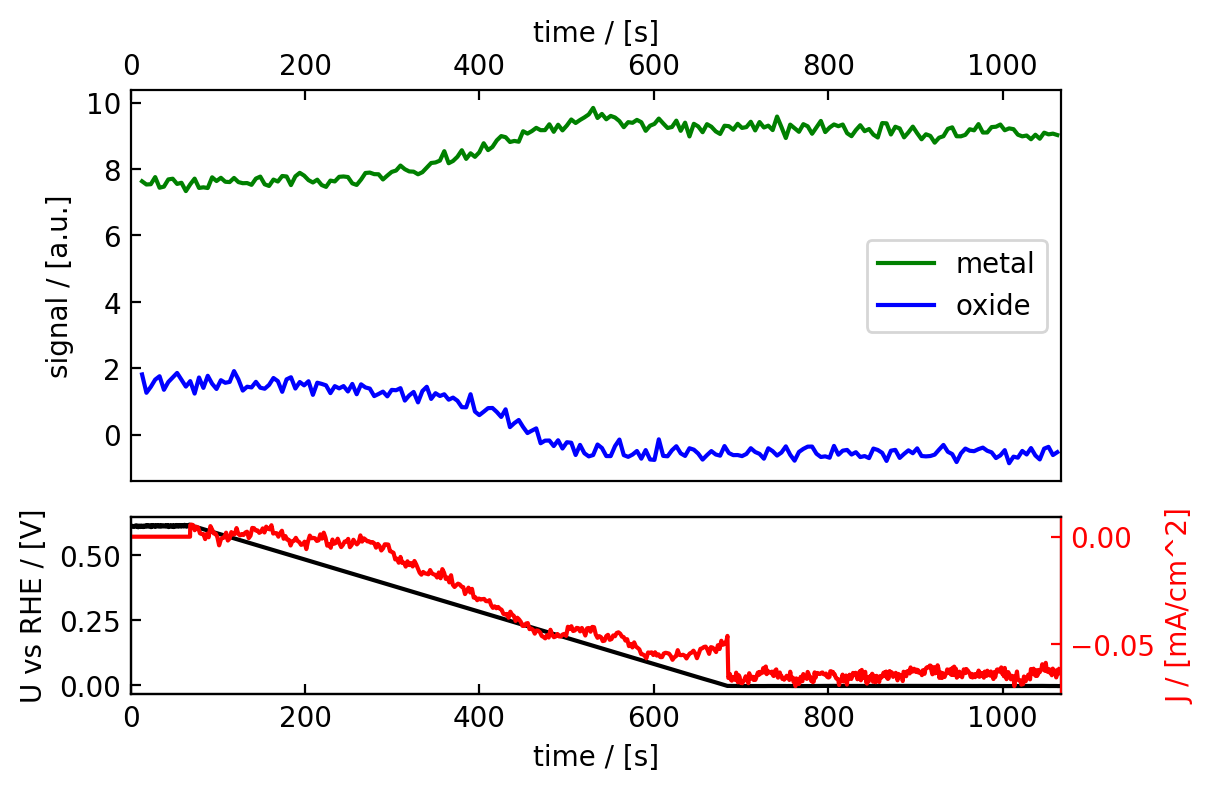

In [12]:
peaks = {'metal':([19.5, 20.7], 'g'),
         'oxide':([16.3, 17.5], 'b')}
scan.integrate_peaks(peaks=peaks)
ax = plot_experiment(scan, plot_type='peaks')
ax[0].legend()

## Extracting integrals and plotting vs potential

The peak integrals can be accessed for export or further analysis in <b>scan.data</b>. Here, the peak integrals are manually plotted against potential for the linear sweep. This also shows a useful feature of the <b>EC_Xray.load_EC_set()</b> function: it stores the file number when importing multiple files. 

An interpolation step is necessary. The function <b>EC_Xray.plot_vs_potential()</b> (not shown in this tutorial) offers the same functionality as the following code.

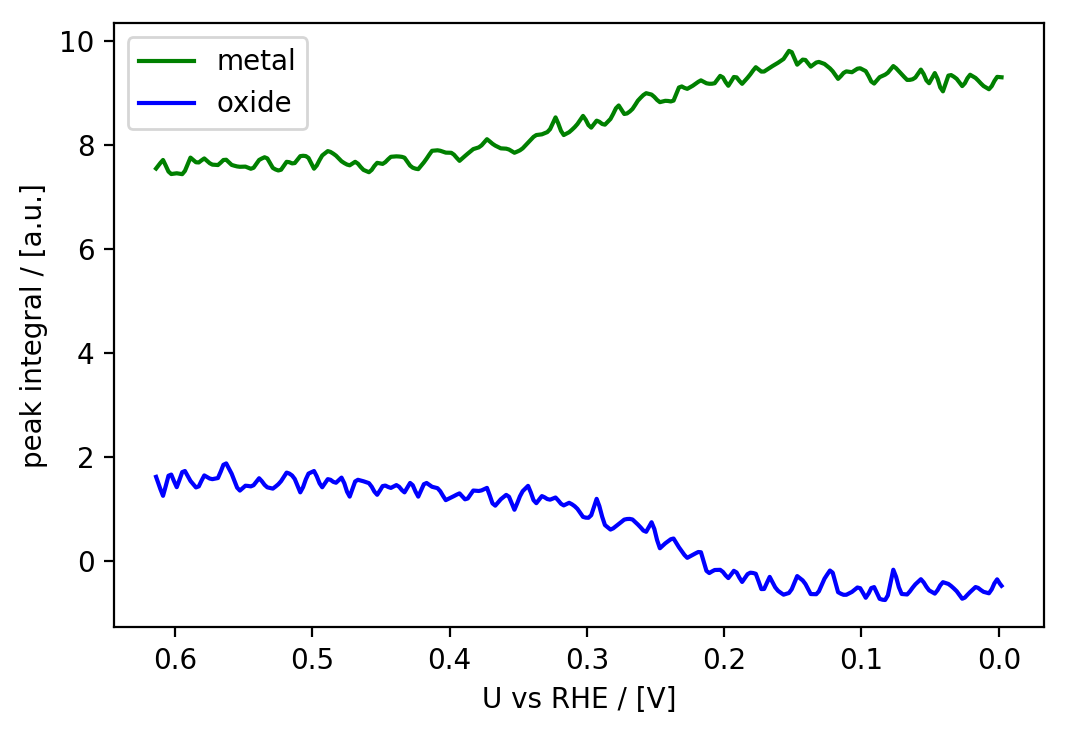

In [13]:
mask = scan.data['file number'] == 1 # selects EC data from LSV
V = scan.data[V_str][mask]    # potential from LSV
t = scan.data['time/s'][mask] # time for LSV data
# To plot vs potential, we have to interpolate onto EC time variable
t_Xray = scan.data['t']
metal = np.interp(t, t_Xray, scan.data['metal'])
oxide = np.interp(t, t_Xray, scan.data['oxide']) 
# now, we're ready to plot!
fig, ax = plt.subplots()
ax.plot(V, metal, 'g')
ax.plot(V, oxide, 'b')
ax.legend(['metal', 'oxide'])
ax.set_ylabel('peak integral / [a.u.]')
ax.set_xlabel(V_str)
ax.invert_xaxis()

# Background subtraction

Another really nice way to see changes is to subtract a background. This can be done in a number of ways with <b>EC_Xray.ScanImages.subtract_background()</b>. The arguments here are interpreted as follows:

* <b>background</b> is the value for which the tth is considered the background spctrum
* <b>background_type</b> explains what that value refers to

Here, the spectrum at 0.05 V vs RHE is taken to be the background. (Remember that <b>V_str</b> is the name of the calibrated potential data, returned earlier from <b>EC_Xray.sync_metadata()</b>.) The function's output gives an idea how it actually does that.

The background-subtracted spectra is saved and used by default untless <b>scan.bg</b> is set to <b>False</b>. Plotting the experiment with the background-subtracted spectra here shows makes the disappearance of the oxide peak much clearer.



function 'subtract_background' at your service!



function 'get_stacked_spectra' at your service!

using the already-calculated image spectra
self.spectra.shape = (240, 105)

function 'get_stacked_spectra' finished!


going to interpolate to U vs RHE / [V] = 0.1
WARNING! self.data['U vs RHE / [V]'] is not monotonially increasing.
 I'll try to fix it but no guarantee...
got this error: x and y arrays must be equal in length along interpolation axis.
...gonna try interpolating to 't' first.
t.shape = (240,), spectra.shape = (240, 105)
using a direction mask to interpolate on a monotonically increasing list.
This will get the first time U vs RHE / [V] passes 0.1
will use the image spectrum corresponding to time/s = 582.3106743332025 as background.
Inputs make sense: 
A constant background spectrum will be subtracted from each image spectrum in self.spectra

function 'subtract_background' finished!




function 'plot_experiment' at your service!


syncing metadata for (time_scan.csv) as

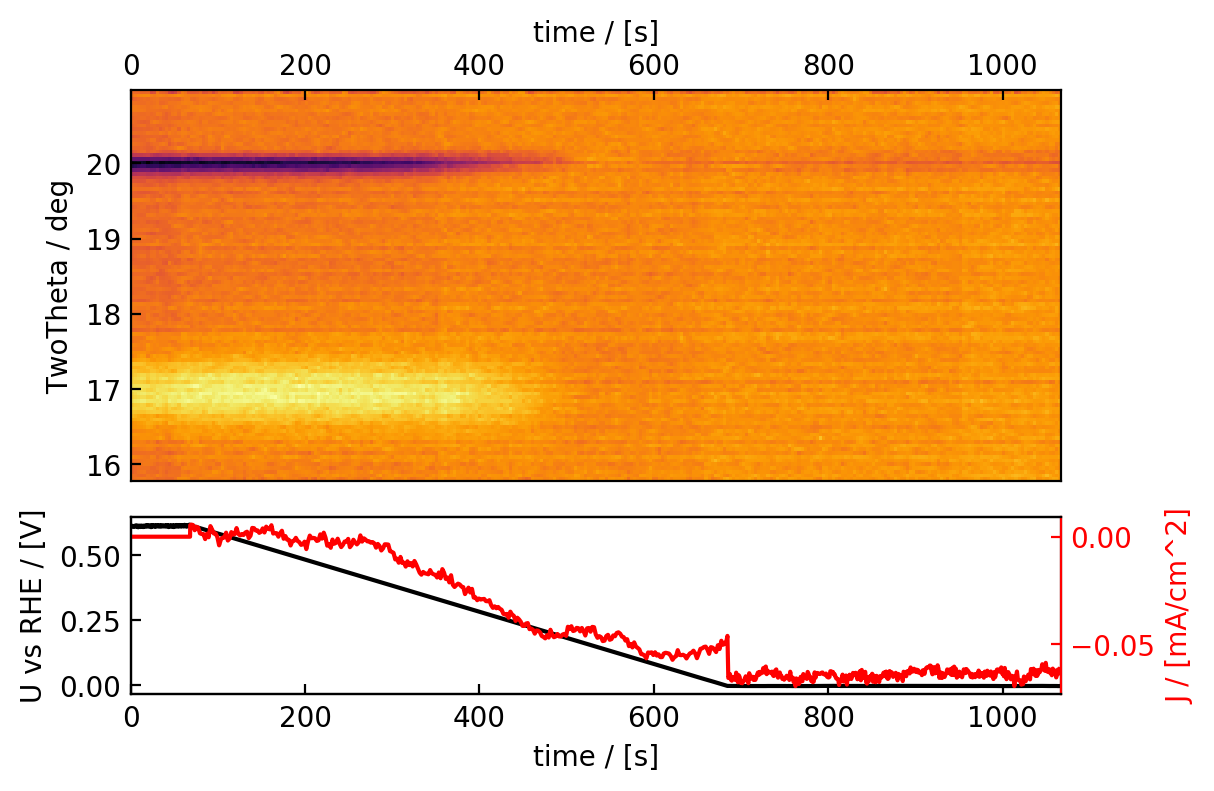

In [14]:
scan.subtract_background(background = 0.1, 
                         background_type = V_str
                         )
ax = plot_experiment(scan, plot_type='heat', bg=True)


## Dynamic displays

You can do other cool stuff like making movies, which I'll leave out here. The functions are <b>EC_Xray.ScanImages.make_movie()</b> and <b>EC_Xray.ScanImages.make_spectrum_movie()</b>. The later colors in the peaks if you've integrated using <b>EC_Xray.ScanImages.integrate_peaks()</b>

# Conclusion

EC_Xray is a collection of powerful object-oriented python tools for analyzing diffraction data in combination with electrochemistry data. This demonstration shows how to load, synchronize, and plot raw data and derived values for a simple in-situ synchrotron electrochemistry experiment.

# Contact

Fhe EC_Xray python package is available at: github.com/ScottSoren

For collaboration/suggestions, contact: scott@fysik.dtu.dk